In [1]:
# Mount gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Change Directory

In [4]:
%cd "/content/drive/My Drive/UCM/tfm_code/notebooks"

/content/drive/My Drive/UCM/tfm_code/notebooks


In [5]:
# Import Libraries

In [6]:
# Downloaded
import pandas as pd
import pyarrow
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score,make_scorer
from sklearn.model_selection import  StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import ast

In [7]:
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
# Codigo

In [26]:
df = pd.read_parquet(engine="pyarrow", path="/content/drive/My Drive/UCM/tfm_code/data/data_modelo_train_cleaned.parquet")

In [27]:
df = df[df['SEMANA'].isin([17,16,15,14])]
df.drop(columns=['CLIENTE_ID','PRODUCTO_ID','ANIO','SEMANA'], inplace=True)

In [28]:
X = df.drop(columns=['PURCHASE'], axis=1)
y = df['PURCHASE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,random_state=42)

In [29]:
del(df)
del(X)
del(y)
del(X_train)
del(y_train)

In [30]:
np.random.seed(1234)

In [31]:
scoring = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

In [33]:
def rfecv_feature_selection(modelo, min_feature,model_name):
  rfecv = RFECV(
    estimator=modelo,
    cv=StratifiedKFold(4),
    step=3,
    scoring='average_precision',
    min_features_to_select=min_feature,
    n_jobs=-1 )
  rfecv.fit(X_test, y_test)
  print(f"Optimal number of features: {rfecv.n_features_}")
  print("Selected features: %s" % rfecv.support_)
  final_cols = np.array(X_test.columns)[rfecv.support_]
  print(rfecv.cv_results_["mean_test_score"])
  print(rfecv.cv_results_["std_test_score"])
  plt.style.use("bmh")
  n_scores = len(rfecv.cv_results_["mean_test_score"])
  plt.figure(figsize=(12,8))
  plt.xlabel("Number of features selected", fontsize=16)
  plt.ylabel("Mean test Average Precision ", fontsize=16)
  plt.errorbar(
      range(min_feature, n_scores*3+min_feature,3),
      rfecv.cv_results_["mean_test_score"],
      yerr=rfecv.cv_results_["std_test_score"],
  )
  plt.yticks(fontsize=12)
  plt.xticks(fontsize=12)
  plt.title(model_name, fontsize=20)
  plt.show()
  return final_cols, rfecv

In [34]:
min_feature = 15

In [35]:
# Modelo XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42,
    objective='binary:logistic', 
    eval_metric='aucpr'
)
# Modelo LightGBM
model_lgb = lgb.LGBMClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42,
    objective='binary',
    metric='average_precision'
)
# Modelo Regresión Logística
model_log = LogisticRegression(penalty='l1',solver='saga')

# Modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)


Optimal number of features: 35
Selected features: [ True  True  True  True  True False False  True False False False False
 False False False  True False  True  True  True  True False  True  True
 False  True False  True  True False False False  True  True False  True
  True  True  True  True False  True False  True False  True False  True
  True False  True  True  True  True False  True  True False  True]
[0.67302948 0.67592325 0.67628823 0.67652897 0.67658169 0.6759302
 0.67645975 0.67687561 0.67685727 0.67663663 0.67636611 0.67633825
 0.67679589 0.67622299 0.67659825 0.67651534]
[0.00262906 0.00231408 0.00214375 0.00178979 0.00219136 0.00242046
 0.00206115 0.00206802 0.00206832 0.00207514 0.00196646 0.00186627
 0.00210977 0.00227747 0.00212686 0.00227527]


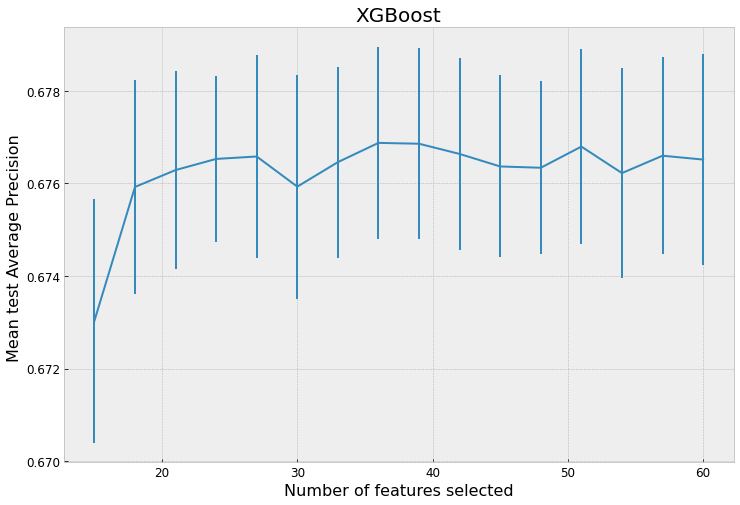

array(['FRECUENCIA', 'RECENCY', 'DURATION_CLIENT', 'TAMANIO',
       'UNIDAD_EMPAQUE', 'CANAL_RSR', 'SUBCANAL_OTHER',
       'SUBCANAL_VINATERÍA', 'MARCA_CIEL', 'MARCA_COCA-COLA',
       'MARCA_DEL VALLE', 'MARCA_FANTA', 'MARCA_FRESCA', 'MARCA_FUZE',
       'MARCA_MONSTER - PREDATOR', 'MARCA_MUNDET', 'MARCA_SANTA CLARA',
       'MARCA_SPRITE', 'MARCA_YOLI - SENZAO-AMEYAL', 'SABOR_COLA',
       'SABOR_FRUTAS', 'SABOR_LIMA-LIMON', 'SABOR_MANGO', 'SABOR_MORAS',
       'SABOR_NATURAL', 'SABOR_UVA', 'EMPAQUE_PET', 'EMPAQUE_REF PET',
       'EMPAQUE_VIDRIO', 'TIPO_CONSUMO_PERSONALES (SS)', 'CLUSTER_1',
       'CLUSTER_2', 'ROTATION_MEAN_CF', 'ROTATION_MEAN_DAYS', 'CF_LOG'],
      dtype=object)

In [36]:
xgb_cols, xgboost_rfe_model = rfecv_feature_selection(model_xgb, min_feature,"XGBoost")
xgb_cols

Optimal number of features: 41
Selected features: [ True  True  True  True  True  True  True False False False False False
  True  True  True  True False  True  True  True  True False  True  True
 False  True  True  True  True False False False  True  True False  True
  True  True False  True  True  True False  True  True False False  True
  True False  True  True  True  True False  True  True  True  True]
[0.6773044  0.67752658 0.67777592 0.67772319 0.67785024 0.6779264
 0.67793345 0.67797217 0.67769318 0.67803331 0.67803236 0.67792448
 0.67780662 0.67789504 0.67786273 0.67784416]
[0.00229069 0.00230221 0.00237696 0.00204596 0.00226016 0.00227941
 0.0022391  0.0022495  0.00224525 0.0021714  0.00224493 0.00225754
 0.00231646 0.00234192 0.00237925 0.00229914]


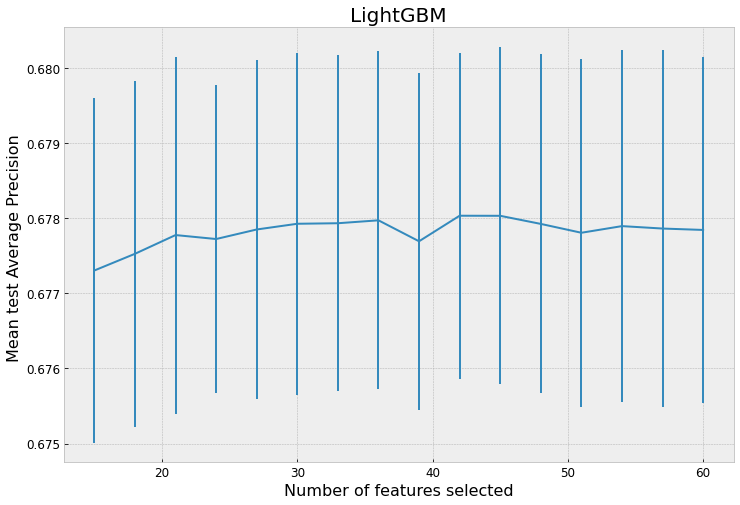

array(['FRECUENCIA', 'RECENCY', 'DURATION_CLIENT', 'TAMANIO',
       'UNIDAD_EMPAQUE', 'CANAL_COMERCIO DE ABARROTES', 'CANAL_OTROS',
       'SUBCANAL_HOGAR CON VENTA', 'SUBCANAL_MINI SUPER INDEPENDIENTE',
       'SUBCANAL_MISCELÁNEA', 'SUBCANAL_OTHER', 'SUBCANAL_VINATERÍA',
       'MARCA_CIEL', 'MARCA_COCA-COLA', 'MARCA_DEL VALLE', 'MARCA_FANTA',
       'MARCA_FRESCA', 'MARCA_FUZE', 'MARCA_MEZCLADA/MULTIPRODUC',
       'MARCA_MONSTER - PREDATOR', 'MARCA_MUNDET', 'MARCA_SANTA CLARA',
       'MARCA_SPRITE', 'MARCA_YOLI - SENZAO-AMEYAL', 'SABOR_COLA',
       'SABOR_FRUTAS', 'SABOR_MANGO', 'SABOR_MANZANA', 'SABOR_MORAS',
       'SABOR_NATURAL', 'SABOR_OTROS', 'EMPAQUE_PET', 'EMPAQUE_REF PET',
       'EMPAQUE_VIDRIO', 'TIPO_CONSUMO_PERSONALES (SS)', 'CLUSTER_1',
       'CLUSTER_2', 'ROTATION_MEAN_CF', 'ROTATION_MEAN_DAYS',
       'ROTATION_MEDIAN_DAYS', 'CF_LOG'], dtype=object)

In [37]:
lgb_cols, lgb_rfe_model = rfecv_feature_selection(model_lgb, min_feature,"LightGBM")
lgb_cols

Optimal number of features: 41
Selected features: [ True  True  True  True False False False  True False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True  True  True  True  True False False
  True  True  True  True  True  True  True  True  True False  True]
[0.66693038 0.66699831 0.66720819 0.66755158 0.66785626 0.66817058
 0.66884111 0.66888097 0.66912265 0.66916604 0.66913256 0.66913448
 0.6691402  0.66913708 0.66913706 0.66913704]
[0.00315878 0.00317393 0.00312391 0.00264898 0.00287053 0.00276143
 0.00300649 0.00297437 0.00280261 0.00281647 0.00282023 0.00282794
 0.00282775 0.00280892 0.00280959 0.00280957]


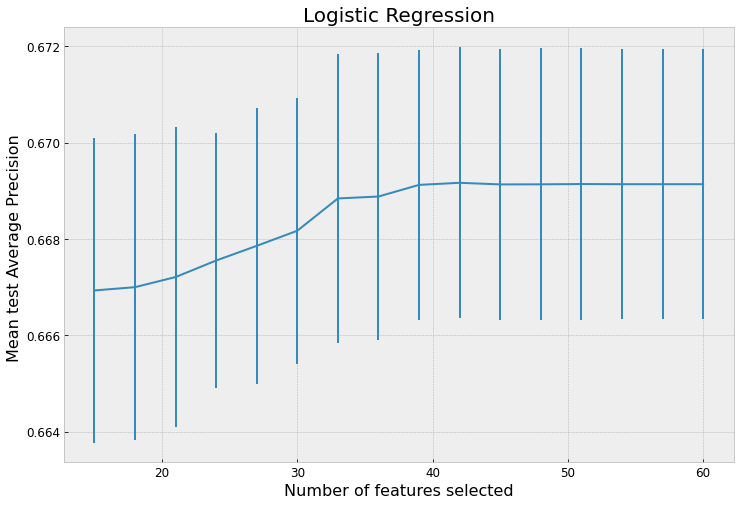

array(['FRECUENCIA', 'RECENCY', 'DURATION_CLIENT', 'TAMANIO', 'CANAL_RSR',
       'MARCA_CIEL', 'MARCA_COCA-COLA', 'MARCA_DEL VALLE',
       'MARCA_DELAWARE PUNCH', 'MARCA_FANTA', 'MARCA_FRESCA',
       'MARCA_FRUTSI', 'MARCA_FUZE', 'MARCA_MEZCLADA/MULTIPRODUC',
       'MARCA_MONSTER - PREDATOR', 'MARCA_MUNDET', 'MARCA_NADAS',
       'MARCA_OTROS', 'MARCA_POWERADE', 'MARCA_SANTA CLARA',
       'MARCA_SPRITE', 'MARCA_TOPO CHICO', 'MARCA_YOLI - SENZAO-AMEYAL',
       'SABOR_FRUTAS', 'SABOR_LIMA-LIMON', 'SABOR_MANZANA', 'SABOR_MORAS',
       'SABOR_NARANJA', 'SABOR_NATURAL', 'SABOR_OTROS', 'SABOR_UVA',
       'EMPAQUE_REF PET', 'EMPAQUE_TETRAPACK', 'EMPAQUE_VIDRIO',
       'TIPO_CONSUMO_PERSONALES (SS)', 'CLUSTER_1', 'CLUSTER_2',
       'CLUSTER_3', 'ROTATION_MEAN_CF', 'ROTATION_MEAN_DAYS', 'CF_LOG'],
      dtype=object)

In [38]:
log_cols, log_rfe_model = rfecv_feature_selection(model_log, min_feature,"Logistic Regression")
log_cols

Optimal number of features: 17
Selected features: [ True  True False  True  True False False False False False False False
 False False False False False False  True  True  True False False False
 False False False False  True False False False False False False False
  True False False False False False False  True False False False False
 False False  True  True  True False False  True  True  True  True]
[0.66746571 0.66833537 0.66711006 0.66530035 0.66614167 0.66530521
 0.66398105 0.66380162 0.66442988 0.66327364 0.66367657 0.66046643
 0.66251056 0.6615893  0.6622484  0.66050924]
[0.00280217 0.00279324 0.00284526 0.00290684 0.00303955 0.00322326
 0.00321951 0.00302467 0.00307437 0.00339888 0.0028459  0.00418539
 0.00348756 0.0030803  0.00362182 0.00298707]


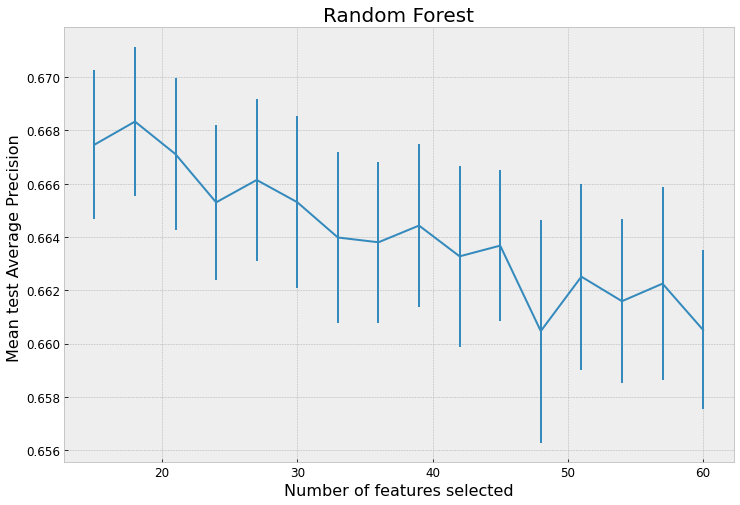

array(['FRECUENCIA', 'RECENCY', 'TAMANIO', 'UNIDAD_EMPAQUE', 'MARCA_CIEL',
       'MARCA_COCA-COLA', 'MARCA_DEL VALLE', 'MARCA_MUNDET', 'SABOR_COLA',
       'SABOR_NATURAL', 'EMPAQUE_VIDRIO', 'TIPO_CONSUMO_PERSONALES (SS)',
       'CLUSTER_1', 'ROTATION_MEAN_CF', 'ROTATION_MEAN_DAYS',
       'ROTATION_MEDIAN_DAYS', 'CF_LOG'], dtype=object)

In [39]:
random_forest_cols, rf_rfe_model = rfecv_feature_selection(model_rf, min_feature,"Random Forest")
random_forest_cols